# Welcome to PySpark and Amazon Elastic Map-Reduce (EMR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PySpark Specific Machinery
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

import pyspark.sql.functions as F

In [2]:
!hadoop dfsadmin -report

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Configured Capacity: 148067303424 (137.90 GB)
Present Capacity: 144840027358 (134.89 GB)
DFS Remaining: 144785849687 (134.84 GB)
DFS Used: 54177671 (51.67 MB)
DFS Used%: 0.04%
Under replicated blocks: 0
Blocks with corrupt replicas: 0
Missing blocks: 0
Missing blocks (with replication factor 1): 0
Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (2):

Name: 172.31.33.71:50010 (ip-172-31-33-71.ec2.internal)
Hostname: ip-172-31-33-71.ec2.internal
Decommission Status : Normal
Configured Capacity: 74033651712 (68.95 GB)
DFS Used: 252349 (246.43 KB)
Non DFS Used: 1613656859 (1.50 GB)
DFS Remaining: 72419742504 (67.45 GB)
DFS Used%: 0.00%
DFS Remaining%: 97.82%
Configured Cache Capacity: 0 (0 B)
Cache Used: 0 (0 B)
Cache Remaining: 0 (0 B)
Cache Used%: 100.00%
Cache Remaining%: 0.00%
Xceivers: 1
Last contact: Thu Sep 20 03:43:11 UTC 2018


Na

*** 

Preliminaries

*** 

The SparkSession object represents your entrypoint to the cluster. It is the single most important object in Spark and serves as the mechanism through which you will interact with the Hadoop resources provisioned for you. Every Spark "job" - i.e. an individual spark applicaton run by a user, will have a uniqe SparkContext that in some abstract sense 'contains' the resources allocated to that job at all times. For that reason each job only has one SparkContext - if you try and create a second one, you'll get an error (depending on cluster configuration parameters).

In [3]:
spark = SparkSession.builder\
    .master("yarn")\
    .config("spark.driver.cores", 1)\
    .appName("demo_spark")\
    .getOrCreate()

In [4]:
spark

You can exit the SparkSession using the following switch, however if you need the resources back you might need to wait for your cluster availability to swing back in your favor (so be careful especially if you suspect your co-workers overuse cluster resources)

In [5]:
# spark.stop() # shuts down the sparkcontext - but not the notebook.

# The Resilient Distributed Dataset

RDDs are the core object of study in Spark and form the backbone of the architecture that makes it work. An RDD can be thought of as a complex plan for creating a dataset in parallel - a dataset that will in the end, exist on disk in many pieces. Since it starts in many pieces, the RDD represents the set of partition level plans to build the dataset from scratch in parallel. When thought of in this way it makes sense that if something happens and a single node fails, Spark doesn't have to regenerate the entire dataset - it can just regenerate the specific partitions related to the node that failed. This is very in-pattern when considered as an application of the Hadoop infrastructure.

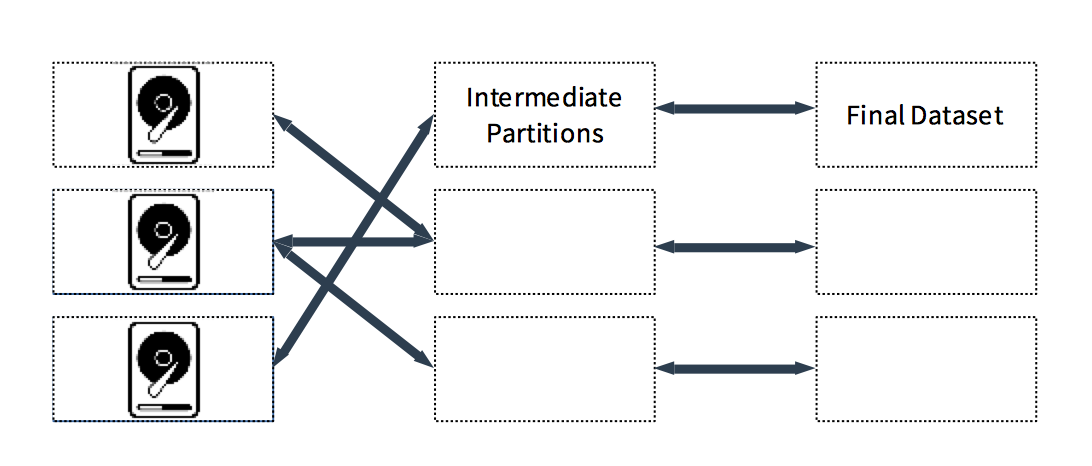

In [6]:
from IPython.display import Image
Image(filename='../rdd.png')

Let's create a dataframe in Pandas and promote it to a Spark dataframe, which is a tabular data structure built on top of the RDD engine.

In [7]:
df = pd.DataFrame.from_dict({
        'A': [1,2,3],
        'B': ['a','b','c']
    })

In [8]:
df.head()

,A,B
0,1,a
1,2,b
2,3,c


In [9]:
sp_df = spark.createDataFrame(df)

In [10]:
sp_df.show()

+---+---+
|  A|  B|
+---+---+
|  1|  a|
|  2|  b|
|  3|  c|
+---+---+



# DAGs and Lazy Execution


Lazy execution is a feature built into spark designed both to make development easier for you as well as minimize overuse of cluster resources. In one sentence, it means that Spark doesn't compute anything it doesn't absolutely have to. In Spark, you write the majority of the program in a manner that specifies a PLAN of WHAT youw WANT to happen - and then trigger the actual execution of the plan later. Let's see how this actually works in practice

In [ ]:
data = spark.read.parquet('data/subset_reviews_parquet/')

In [ ]:
data.explain()

In [ ]:
best_scores = data.where(F.col('Score') == '5')

In [ ]:
best_scores

In [ ]:
best_scores.explain()

In [ ]:
best_scores.select('Score', 'Text').show()

Long story short, doing something to a datset via some code in this notebook doesn't actually do anything to materialize the real data until you force it too - you can think of successive dataframe manipulations as simply adding steps to the plan for what will later happen. This is advantageous for the programmer as well as the cluster - you don't want to have to compute the entire dataset every time you want to change something. You can make it pretty far without actually materializing anything however - generally when developing data science workflows you make many errors just trying to match up the right metadata anyways.

# Parallel I/O 

In [55]:
data.repartition(100, 'Id').write.mode('overwrite').parquet('data/reviews_repartitioned/')

In [56]:
!hadoop fs -ls data/reviews_repartitioned/ 

Found 101 items
-rw-r--r--   1 hadoop hadoop          0 2018-09-17 21:38 data/reviews_repartitioned/_SUCCESS
-rw-r--r--   1 hadoop hadoop     305378 2018-09-17 21:38 data/reviews_repartitioned/part-00000-f9174d7b-2d4f-4cc9-a239-be6570962f26-c000.snappy.parquet
-rw-r--r--   1 hadoop hadoop     303826 2018-09-17 21:38 data/reviews_repartitioned/part-00001-f9174d7b-2d4f-4cc9-a239-be6570962f26-c000.snappy.parquet
-rw-r--r--   1 hadoop hadoop     309668 2018-09-17 21:38 data/reviews_repartitioned/part-00002-f9174d7b-2d4f-4cc9-a239-be6570962f26-c000.snappy.parquet
-rw-r--r--   1 hadoop hadoop     301403 2018-09-17 21:38 data/reviews_repartitioned/part-00003-f9174d7b-2d4f-4cc9-a239-be6570962f26-c000.snappy.parquet
-rw-r--r--   1 hadoop hadoop     323638 2018-09-17 21:38 data/reviews_repartitioned/part-00004-f9174d7b-2d4f-4cc9-a239-be6570962f26-c000.snappy.parquet
-rw-r--r--   1 hadoop hadoop     314255 2018-09-17 21:38 data/reviews_repartitioned/part-00005-f9174d7b-2d4f-4cc9-a239-be6570962f26

In [57]:
!hadoop fs -ls data/reviews_repartitioned/ | wc -l

102


In [ ]:
data = spark.read.csv('data/Subset_reviews.csv', header='true')

In [ ]:
data.show()

In [ ]:
data.printSchema()

In [13]:
data.write.parquet('data/subset_reviews_parquet/')

In [15]:
data.groupBy('Score').count().show()

+--------------+-----+
|         Score|count|
+--------------+-----+
|       Hugs"""|    1|
|             7|    7|
|     friend"""|    1|
|            11|    1|
|             3| 8019|
|             8|    1|
| and Kitten"""|   26|
|        Dad"""|    1|
|            16|    1|
|             0|  206|
|            47|    5|
|   Comp sci"""|    1|
|          null|    2|
|             5|62148|
|            18|    1|
|       blo..."|    1|
|     Medit..."|    1|
|            17|    1|
|     Lyme ..."|    1|
|          ..."|    7|
+--------------+-----+
only showing top 20 rows



In [22]:
data = spark.read.parquet('data/subset_reviews_parquet')

In [18]:
data.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [19]:
data.explain()

== Physical Plan ==
*(1) FileScan parquet [Id#143,ProductId#144,UserId#145,ProfileName#146,HelpfulnessNumerator#147,HelpfulnessDenominator#148,Score#149,Time#150,Summary#151,Text#152] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://ip-172-31-32-61.ec2.internal:8020/user/hadoop/data/subset_reviews_parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Id:string,ProductId:string,UserId:string,ProfileName:string,HelpfulnessNumerator:string,He...


In [24]:
data.groupBy('Score').count().sort(F.col('count').desc()).show()

+------------------+-----+
|             Score|count|
+------------------+-----+
|                 5|62148|
|                 4|14537|
|                 1| 9392|
|                 3| 8019|
|                 2| 5582|
|                 0|  206|
|     and Kitten"""|   26|
|   book-blogger"""|   13|
|                 6|    9|
|                 7|    7|
|              ..."|    7|
|             RN"""|    6|
|                47|    5|
|                10|    5|
|     Music Fan..."|    3|
|                14|    3|
| and book lover"""|    3|
|        swimme..."|    2|
|             a..."|    2|
|                33|    2|
+------------------+-----+
only showing top 20 rows



In [22]:
import pyspark.sql.functions as F

In [11]:
names = ['Alice',
         'Bob',
         'James',
         'Beth', 
         'John', 
         'Sally',
         'Richard', 
         'Lauren',
         'Brandon', 
         'Sabrina']

ages = np.random.randint(18,35, len(names))# Some random ages between 18 and 35
my_dict = {'names':names, 'ages':ages}
print(my_dict)

{'names': ['Alice', 'Bob', 'James', 'Beth', 'John', 'Sally', 'Richard', 'Lauren', 'Brandon', 'Sabrina'], 'ages': array([33, 32, 33, 21, 23, 31, 22, 19, 34, 24])}


In [12]:
df = pd.DataFrame.from_dict(my_dict)


In [13]:
sp_df = spark.createDataFrame(df)

In [15]:
sp_df.limit(10).show()

+----+-------+
|ages|  names|
+----+-------+
|  33|  Alice|
|  32|    Bob|
|  31|  Sally|
|  22|Richard|
|  19| Lauren|
|  34|Brandon|
|  24|Sabrina|
|  33|  James|
|  21|   Beth|
|  23|   John|
+----+-------+



In [17]:
sp_df.sort('names').show()

+----+-------+
|ages|  names|
+----+-------+
|  33|  Alice|
|  21|   Beth|
|  32|    Bob|
|  34|Brandon|
|  33|  James|
|  23|   John|
|  19| Lauren|
|  22|Richard|
|  24|Sabrina|
|  31|  Sally|
+----+-------+



In [22]:
df.where(F.col('ages').cast(IntegerType()) > 19).show()

Py4JJavaError: An error occurred while calling o171.notEqual.
: java.lang.RuntimeException: Unsupported literal type class java.util.ArrayList [10, 2]
	at org.apache.spark.sql.catalyst.expressions.Literal$.apply(literals.scala:77)
	at org.apache.spark.sql.catalyst.expressions.Literal$$anonfun$create$2.apply(literals.scala:163)
	at org.apache.spark.sql.catalyst.expressions.Literal$$anonfun$create$2.apply(literals.scala:163)
	at scala.util.Try.getOrElse(Try.scala:79)
	at org.apache.spark.sql.catalyst.expressions.Literal$.create(literals.scala:162)
	at org.apache.spark.sql.functions$.typedLit(functions.scala:113)
	at org.apache.spark.sql.functions$.lit(functions.scala:96)
	at org.apache.spark.sql.Column.notEqual(Column.scala:337)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [21]:
from pyspark.sql.types import IntegerType

In [23]:
# Generate some fake data
customer_id = np.random.randint(1000,1100, 10)
renewal_nbr = np.random.randint(0,10,10)
term_in_years = [{1:0.5,0:1}[key] for key in np.random.randint(0,2,10)]

# Create a dict - not usually how you would do this
rand_data = {'customer_id':customer_id, 'renewal_nbr':renewal_nbr, 'term_in_years':term_in_years}

# Build the dataframe
customers = pd.DataFrame.from_dict(rand_data)
customers.head(10)

,customer_id,renewal_nbr,term_in_years
0,1093,8,1.0
1,1086,6,1.0
2,1080,5,1.0
3,1025,3,1.0
4,1041,7,0.5
5,1058,3,0.5
6,1089,3,0.5
7,1043,0,1.0
8,1071,2,1.0
9,1082,9,0.5


In [ ]:
customers['customer_tenure'] = customers['renewal_nbr'] * customers['term_in_years']
customers.head(10)

In [ ]:
customers['ages'] = np.random.randint(16, 70, 10)

def make_age_groups(age):
    if 10 <= age and 20 > age:
        return 'Teenager'
    if 20 <= age and 35 > age:
        return 'Young Adult'
    if 35 <= age and 65 > age:
        return 'Adult'
    if 65 <= age:
        return 'Senior'
    
customers['age_group'] = customers['ages'].apply(make_age_groups)
customers.head(10)

In [ ]:
customers.groupby(['age_group', 'term_in_years'], as_index=False).mean().head()

In [ ]:
city_dict = {1:'Chicago',2:'San Fransisco',3:'New York', 4:'Boston', 5:'Houston'}

ages = np.random.randint(18,65,100)
city = [city_dict[num] for num in np.random.randint(1,6,100)]
customer_id = np.arange(1000,1100)

In [ ]:
# Generate some other fake data
customer_id = np.random.randint(1000,1200,100)
customer_rating = np.random.randint(0,10,100)

surveys = pd.DataFrame.from_dict({'customer_id':customer_id, 'customer_rating':customer_rating})
surveys.sort_values('customer_id', ascending=True).head()

In [ ]:
demographic_ratings = cust_demographics.merge(surveys, on='customer_id', how='inner')
demographic_ratings.head()

# Putting it All Together

Let's look at the distribution of scores

In [16]:
data.groupBy('Score')\
    .count()\
    .show()

+--------------+-----+
|         Score|count|
+--------------+-----+
|       Hugs"""|    1|
|             7|    7|
|     friend"""|    1|
|            11|    1|
|             3| 8019|
|             8|    1|
| and Kitten"""|   26|
|        Dad"""|    1|
|            16|    1|
|             0|  206|
|            47|    5|
|   Comp sci"""|    1|
|          null|    2|
|             5|62148|
|            18|    1|
|       blo..."|    1|
|     Medit..."|    1|
|            17|    1|
|     Lyme ..."|    1|
|          ..."|    7|
+--------------+-----+
only showing top 20 rows



In [18]:
data.groupBy('Score')\
    .count()\
    .sort(F.col('count').desc())\
    .show()

+------------------+-----+
|             Score|count|
+------------------+-----+
|                 5|62148|
|                 4|14537|
|                 1| 9392|
|                 3| 8019|
|                 2| 5582|
|                 0|  206|
|     and Kitten"""|   26|
|   book-blogger"""|   13|
|                 6|    9|
|                 7|    7|
|              ..."|    7|
|             RN"""|    6|
|                10|    5|
|                47|    5|
|     Music Fan..."|    3|
| and book lover"""|    3|
|                14|    3|
|        swimme..."|    2|
|             a..."|    2|
|            mom"""|    2|
+------------------+-----+
only showing top 20 rows



In [23]:
data = data.where(F.col('Score').isin(['0','1','2','3','4','5']))

In [24]:
data.groupBy('Score')\
    .count()\
    .sort(F.col('count').desc())\
    .show()

+-----+-----+
|Score|count|
+-----+-----+
|    5|62148|
|    4|14537|
|    1| 9392|
|    3| 8019|
|    2| 5582|
|    0|  206|
+-----+-----+



In [25]:
data.explain()

== Physical Plan ==
*(1) Filter Score#155 IN (0,1,2,3,4,5)
+- *(1) FileScan parquet [Id#149,ProductId#150,UserId#151,ProfileName#152,HelpfulnessNumerator#153,HelpfulnessDenominator#154,Score#155,Time#156,Summary#157,Text#158] Batched: true, Format: Parquet, Location: InMemoryFileIndex[hdfs://ip-172-31-32-61.ec2.internal:8020/user/hadoop/data/subset_reviews_parquet], PartitionFilters: [], PushedFilters: [In(Score, [0,1,2,3,4,5])], ReadSchema: struct<Id:string,ProductId:string,UserId:string,ProfileName:string,HelpfulnessNumerator:string,He...


In [26]:
data.count()

99884

In [27]:
# Pull the pieces of the data we want 
scores_rollup_pd = data.groupBy('Score').count().toPandas()

In [28]:
scores_rollup_pd.head()

,Score,count
0,3,8019
1,0,206
2,5,62148
3,1,9392
4,4,14537


In [29]:
scores_rollup_pd = scores_rollup_pd.sort_values('Score')

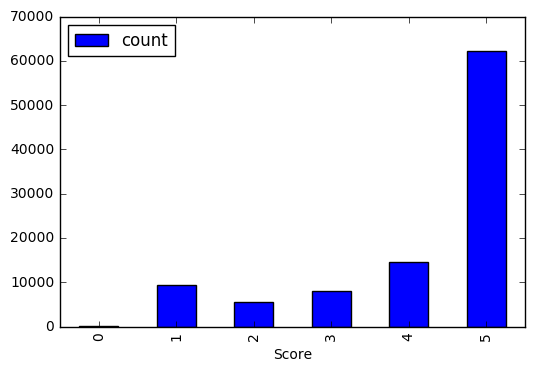

In [36]:
scores_rollup_pd.plot('Score', kind='bar')
plt.show()

In [40]:
data = data.withColumn('h_ratio', F.col('HelpfulnessNumerator') / F.col('HelpfulnessDenominator'))

In [41]:
data.select('HelpfulnessNumerator', 'HelpfulnessDenominator', 'h_ratio').show()

+--------------------+----------------------+------------------+
|HelpfulnessNumerator|HelpfulnessDenominator|           h_ratio|
+--------------------+----------------------+------------------+
|                   3|                     4|              0.75|
|                   3|                     4|              0.75|
|                   3|                     4|              0.75|
|                   3|                     4|              0.75|
|                   5|                     7|0.7142857142857143|
|                   5|                     7|0.7142857142857143|
|                   5|                     7|0.7142857142857143|
|                   2|                     3|0.6666666666666666|
|                   2|                     3|0.6666666666666666|
|                   2|                     3|0.6666666666666666|
|                   2|                     3|0.6666666666666666|
|                   2|                     3|0.6666666666666666|
|                   2|   

In [42]:
h_ratios = data.select('h_ratio').toPandas()

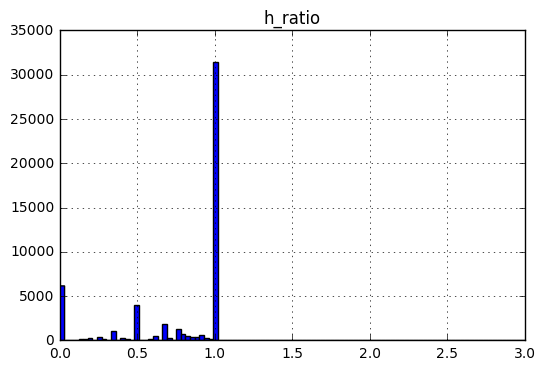

In [46]:
h_ratios.hist('h_ratio', bins=100)
plt.show()

In [48]:
data.sort(F.col('h_ratio').desc()).select('HelpfulnessNumerator', 'HelpfulnessDenominator', 'h_ratio').show()

+--------------------+----------------------+-------+
|HelpfulnessNumerator|HelpfulnessDenominator|h_ratio|
+--------------------+----------------------+-------+
|                   3|                     1|    3.0|
|                   3|                     2|    1.5|
|                   2|                     2|    1.0|
|                   2|                     2|    1.0|
|                  66|                    66|    1.0|
|                   2|                     2|    1.0|
|                  27|                    27|    1.0|
|                   2|                     2|    1.0|
|                   6|                     6|    1.0|
|                  44|                    44|    1.0|
|                   6|                     6|    1.0|
|                   2|                     2|    1.0|
|                   4|                     4|    1.0|
|                   2|                     2|    1.0|
|                   1|                     1|    1.0|
|                   2|      

In [38]:
data.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [ ]:
data.groupBy('Score').count()

In [10]:
data_pd.head()

,Score,count
0,"Hugs""""""",1
1,7,7
2,"friend""""""",1
3,11,1
4,3,8019


Reviewer with the shortest time between reviews

In [58]:
data.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- h_ratio: double (nullable = true)



In [59]:
data.groupBy('UserId').count().sort(F.col('count').desc()).show()

+--------------+-----+
|        UserId|count|
+--------------+-----+
| AY12DBB0U420B|   88|
|A3OXHLG6DIBRW8|   79|
|A1TMAVN4CEM8U8|   66|
|A281NPSIMI1C2R|   64|
|A1YUL9PCJR3JTY|   63|
|A1Z54EM24Y40LL|   54|
|A3PJZ8TU8FDQ1K|   50|
|A31N6KB160O508|   38|
|A3HPCRD9RX351S|   37|
|A2SZLNSI5KOQJT|   36|
|A3TVZM3ZIXG8YW|   35|
|A2Y8IDC1FKGNJC|   33|
|A1P2XYD265YE21|   33|
| AKMEY1BSHSDG7|   32|
|A1X1CEGHTHMBL1|   32|
|A2MUGFV2TDQ47K|   32|
| AY1EF0GOH80EK|   31|
| AQQLWCMRNDFGI|   31|
|A2OWR2PL3DLWS4|   31|
|A2PNOU7NXB1JE4|   31|
+--------------+-----+
only showing top 20 rows



In [61]:
data.select('UserId').dropDuplicates().count()

70359

In [62]:
min_reviews = 10
more_than_10 = data.groupBy('UserId')\
                   .count()\
                   .where(F.col('count') > min_reviews)\
                   .select('UserId')

In [63]:
more_than_10 = more_than_10.cache()

In [64]:
more_than_10.count()

248

In [65]:
reviews_more_than_10 = data.join(more_than_10, on='UserId')

In [66]:
reviews_more_than_10 = reviews_more_than_10.cache()

In [67]:
more_than_10 = more_than_10.unpersist()

In [68]:
reviews_more_than_10.show()

+--------------+-----+----------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+------------------+
|        UserId|   Id| ProductId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|           h_ratio|
+--------------+-----+----------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+------------------+
| ADS5APY1NKTL4|78727|B00472I5A4|  "D. Pawl ""Dani"""|                   5|                     7|    5|1175040000|these potato chip...|I try to be good,...|0.7142857142857143|
|A3M174IC0VXOS2|78730|B00472I5A4|          Gail Cooke|                   2|                     3|    5|1245024000|CRISPY, CRUNCHY, ...|We've long enjoye...|0.6666666666666666|
|A2OL5WLCNZVD9K|78738|B00472I5A4|           nonpareil|                   0|                     0|    3|1347408000|

In [69]:
reviews_more_than_10.count()

4413

In [70]:
reviews_more_than_10.select('Time').show()

+----------+
|      Time|
+----------+
|1175040000|
|1245024000|
|1347408000|
|1296691200|
|1304467200|
|1304467200|
|1287446400|
|1183593600|
|1333324800|
|1186358400|
|1272240000|
|1335484800|
|1320710400|
|1266192000|
|1323734400|
|1330646400|
|1343952000|
|1285027200|
|1265155200|
|1304985600|
+----------+
only showing top 20 rows



In [71]:
reviews_more_than_10.select(F.from_unixtime('Time')).show()

+----------------------------------------+
|from_unixtime(Time, yyyy-MM-dd HH:mm:ss)|
+----------------------------------------+
|                     2007-03-28 00:00:00|
|                     2009-06-15 00:00:00|
|                     2012-09-12 00:00:00|
|                     2011-02-03 00:00:00|
|                     2011-05-04 00:00:00|
|                     2011-05-04 00:00:00|
|                     2010-10-19 00:00:00|
|                     2007-07-05 00:00:00|
|                     2012-04-02 00:00:00|
|                     2007-08-06 00:00:00|
|                     2010-04-26 00:00:00|
|                     2012-04-27 00:00:00|
|                     2011-11-08 00:00:00|
|                     2010-02-15 00:00:00|
|                     2011-12-13 00:00:00|
|                     2012-03-02 00:00:00|
|                     2012-08-03 00:00:00|
|                     2010-09-21 00:00:00|
|                     2010-02-03 00:00:00|
|                     2011-05-10 00:00:00|
+----------

In [76]:
from pyspark.sql.window import Window
W = Window.partitionBy('UserId').orderBy('Time')
reviews_more_than_10 = reviews_more_than_10.withColumn('date_lag', F.lag('Time').over(W))

In [77]:
reviews_more_than_10.select('UserId', 'Time', 'date_lag').show()

+--------------+----------+----------+
|        UserId|      Time|  date_lag|
+--------------+----------+----------+
|A1I34N9LFOSCX7|1187481600|      null|
|A1I34N9LFOSCX7|1193184000|1187481600|
|A1I34N9LFOSCX7|1194393600|1193184000|
|A1I34N9LFOSCX7|1196812800|1194393600|
|A1I34N9LFOSCX7|1201219200|1196812800|
|A1I34N9LFOSCX7|1227398400|1201219200|
|A1I34N9LFOSCX7|1227398400|1227398400|
|A1I34N9LFOSCX7|1227398400|1227398400|
|A1I34N9LFOSCX7|1349136000|1227398400|
|A1I34N9LFOSCX7|1349136000|1349136000|
|A1I34N9LFOSCX7|1349136000|1349136000|
| ANEDXRFDZDL18|1173744000|      null|
| ANEDXRFDZDL18|1184544000|1173744000|
| ANEDXRFDZDL18|1235520000|1184544000|
| ANEDXRFDZDL18|1266624000|1235520000|
| ANEDXRFDZDL18|1298419200|1266624000|
| ANEDXRFDZDL18|1312416000|1298419200|
| ANEDXRFDZDL18|1312502400|1312416000|
| ANEDXRFDZDL18|1316908800|1312502400|
| ANEDXRFDZDL18|1317772800|1316908800|
+--------------+----------+----------+
only showing top 20 rows



In [81]:
reviews_more_than_10 = reviews_more_than_10.withColumn('datediff', F.datediff(F.from_unixtime(F.col('Time')), 
                                                                              F.from_unixtime(F.col('date_lag'))))

In [82]:
reviews_more_than_10.select('datediff').show()

+--------+
|datediff|
+--------+
|    null|
|      66|
|      14|
|      28|
|      51|
|     303|
|       0|
|       0|
|    1409|
|       0|
|       0|
|    null|
|     125|
|     590|
|     360|
|     368|
|     162|
|       1|
|      51|
|      10|
+--------+
only showing top 20 rows



In [84]:
from pyspark.sql.types import DoubleType


DataFrame[UserId: string, datediff: double]

In [85]:
averages = reviews_more_than_10.select('UserId', F.col('datediff').cast(DoubleType())).groupBy('UserId').agg(F.mean('datediff'))

In [86]:
averages.show()

+--------------+------------------+
|        UserId|     avg(datediff)|
+--------------+------------------+
|A1I34N9LFOSCX7|             187.1|
| ANEDXRFDZDL18|             188.9|
|A2UCZAWAN5QMJQ|              55.3|
| AQLL2R1PPR46X| 79.04166666666667|
|A1GQAKL9CGQLP1|           19.9375|
|A3T0OTH5072YRE| 47.53846153846154|
|A22CW0ZHY3NJH8| 62.31578947368421|
|A2D1LPEUCTNT8X|31.181818181818183|
|A1IH42TUIZ2XJL|110.28571428571429|
|A22Z9R91N8L7IQ|21.181818181818183|
|A19XMHRB3G4DIR|             128.5|
|A3RR2P5IS3DGPR| 73.76470588235294|
| AJLW1DZSHOVGW| 96.16666666666667|
| AY12DBB0U420B| 16.42528735632184|
| AVFA1JB08RG8G| 93.84615384615384|
| ALDAF4VVLFRHP|              12.0|
|A1IRN1M05TPOVT| 35.45454545454545|
|A2YKWYC3WQJX5J|             111.6|
|A106ZCP7RSXMRU|             103.2|
| AW41Q5K4R499D|               0.0|
+--------------+------------------+
only showing top 20 rows



In [87]:
averages.sort(F.col('avg(datediff)')).show()

+--------------+-------------------+
|        UserId|      avg(datediff)|
+--------------+-------------------+
|A3TVZM3ZIXG8YW|                0.0|
|A1N5FSCYN4796F|                0.0|
| ATIHDHZYNQ0EI|                0.0|
|A26NFIQ7KWI8Y7|                0.0|
|A2XNOB1T796Y6B|                0.0|
| AW41Q5K4R499D|                0.0|
| ABDCYK04CL6O4|                0.0|
|A1AEPMPA12GUJ7|                0.0|
|A1M5D0DG09UGVM| 0.2727272727272727|
|A2N2X7L7LB3S6X|0.36363636363636365|
|A36Y4XHEHNGZ7B|                0.5|
|A2PF32UUERJXB8|                0.8|
|A2GEZJHBV92EVR|               1.48|
|A3RMGIKUWGPZOK|  4.315789473684211|
|A29P51TN9KKMU9| 5.2727272727272725|
|A38KP1POQ191WT|                5.7|
|A1HOXKR7OKJ1X1|                6.4|
|A33AQPJYH7UUXR|  7.545454545454546|
|A1X1CEGHTHMBL1|   8.03225806451613|
|A2TJG4N8LNJW23|  9.066666666666666|
+--------------+-------------------+
only showing top 20 rows



In [93]:
data.where(F.col('UserId') == 'A1M5D0DG09UGVM').sort(F.col('Time')).select('UserId', F.from_unixtime('Time'), 'Text').show(100)

+--------------+----------------------------------------+--------------------+
|        UserId|from_unixtime(Time, yyyy-MM-dd HH:mm:ss)|                Text|
+--------------+----------------------------------------+--------------------+
|A1M5D0DG09UGVM|                     2007-07-27 00:00:00|I haven't had any...|
|A1M5D0DG09UGVM|                     2007-07-27 00:00:00|I was very excite...|
|A1M5D0DG09UGVM|                     2007-07-27 00:00:00|I haven't had any...|
|A1M5D0DG09UGVM|                     2007-07-27 00:00:00|I haven't had any...|
|A1M5D0DG09UGVM|                     2007-07-27 00:00:00|I haven't had any...|
|A1M5D0DG09UGVM|                     2007-07-27 00:00:00|These are in the ...|
|A1M5D0DG09UGVM|                     2007-07-28 00:00:00|This is darker an...|
|A1M5D0DG09UGVM|                     2007-07-28 00:00:00|Every can was den...|
|A1M5D0DG09UGVM|                     2007-07-28 00:00:00|I noticed no enha...|
|A1M5D0DG09UGVM|                     2007-07-28 00:0